In [33]:
#https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [178]:
from gtfparse import read_gtf
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler

from lifelines import CoxPHFitter
from lifelines.utils.printer import Printer

%matplotlib inline

In [34]:
from gtfparse import read_gtf
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

%matplotlib inline

In [35]:
GTF = pd.read_pickle("annot.pkl")
GTF

,gene_name,gene_id,length
0,5S_rRNA,ENSG00000252830.2,109
1,5_8S_rRNA,ENSG00000275877.1,151
2,7SK,ENSG00000277313.1,249
3,A1BG,ENSG00000121410.10,8321
4,A1BG-AS1,ENSG00000268895.4,7432
...,...,...,...
58382,snoZ40,ENSG00000201410.1,71
58383,snoZ6,ENSG00000253067.1,67
58384,snosnR66,ENSG00000212397.1,98
58385,uc_338,ENSG00000277916.1,168


In [36]:
mbg = pd.ExcelFile('41586_2011_BFnature10350_MOESM321_ESM.xls').parse('All metabolic genes')
mbg = mbg.rename(columns={'Gene Symbol': 'gene_name'})
mbg

,Gene Name,gene_name,Entrez Gene ID,Classification
0,"ATP-binding cassette, sub-family A (ABC1), mem...",ABCA1,19,ABC Transporter
1,"ATP-binding cassette, sub-family A (ABC1), mem...",ABCA10,10349,ABC Transporter
2,"ATP-binding cassette, sub-family A (ABC1), mem...",ABCA12,26154,ABC Transporter
3,"ATP-binding cassette, sub-family A (ABC1), mem...",ABCA13,154664,ABC Transporter
4,"ATP-binding cassette, sub-family A (ABC1), mem...",ABCA2,20,ABC Transporter
...,...,...,...,...
2747,"pyridoxal (pyridoxine, vitamin B6) phosphatase",PDXP,57026,Vitamin B6
2748,phosphatase orphan 2,PHOSPHO2,493911,Vitamin B6
2749,pyridoxamine 5'-phosphate oxidase,PNPO,55163,Vitamin B6
2750,dicarbonyl/L-xylulose reductase,DCXR,51181,Xyulose


In [37]:
mg = ["NCEH1","EPHX4","EPHX3","AOC1","ASIC2","ASIC1","ASIC3","ASIC4","ASIC5","CCDC102B",
       "AZIN2","ETNPPL","PHYKPL","AK4","AKR1E2","KDM1B","KDM1A","ASAH2B","NAAA","ATP5C1P1","MT-ATP6",
       "MT-ATP8","B4GAT1","BCO1","SLC25A47","SLC17A9","SLC18B1","IDNK","NMRK1","AK8",
       "ADCK3","CES5A","CHKB","CKB","CKMT1B","CLCA3P","CMPK1","MT-CO1","MT-CO2","MT-CO3",
       "CTPS1","CYB561A3","ECI1","AWAT1","AWAT2","DGAT2L7P","DLST","EXT2","ENGASE",
       "CHST15","GALNT16","GALNT15","GALNT18","MOGS","COLGALT1","COLGALT2","GXYLT1",
       "GXYLT2","TECR","PPIP5K2","PPIP5K1","ISCA1P1","KCNE5","CERS1","CERS2",
       "CERS3","CERS4","CERS5","CERS6","ZACN","SLCO1B7","LCLAT1","NAA35","SLC25A51",
       "SLC25A52","SLC25A53","MFSD2A","MARC1","MARC2","NAPEPLD","NAPRT","NAA40",
       "NAA30","NAA50","NAA60","NAA20","NDUFA4P2","PNP","NT5C3A","NT5C3B","SLC51A","SLC51B",
       "LPPR5", "ECI2","HPGDS","PIKFYVE","PKM","PSAT1","MSMO1","SC5D","SDR16C6P",
       "MSRB1","SLC8B1","SLC9C1","SLC9C2","TECRL","ACOT13","UQCR10","UGGT1","UGGT2","UQCR11"]

final_list = set()

final_list.update(set.intersection(set(mbg["gene_name"].tolist()),set(GTF["gene_name"].tolist())))
final_list.update(set(mg))
                  
print(len(final_list))

2743


In [39]:
mgl=pd.read_excel("41586_2011_BFnature10350_MOESM321_ESM.xls",
                  sheet_name="All metabolic genes")
MGL = mgl[["Gene Symbol"]].rename(columns={'Gene Symbol': 'gene_name'})

MGL = MGL.sort_values(by=['gene_name']).reset_index().drop(columns=["index"])
MGL

,gene_name
0,A1CF
1,A4GALT
2,A4GNT
3,AACS
4,AADAC
...,...
2747,XYLB
2748,XYLT1
2749,XYLT2
2750,ZACN


In [8]:
df = pd.DataFrame(sorted(final_list))
df = df.rename(columns={0: 'gene_name'})
df

gtf = pd.merge(df,GTF,on="gene_name")
gtf

,gene_name,gene_id,length
0,A1CF,ENSG00000148584.13,86266
1,A4GALT,ENSG00000128274.14,29177
2,A4GNT,ENSG00000118017.3,8669
3,AACS,ENSG00000081760.15,77954
4,AADAC,ENSG00000114771.12,14451
...,...,...,...
2738,XYLB,ENSG00000093217.8,74588
2739,XYLT1,ENSG00000103489.10,369112
2740,XYLT2,ENSG00000015532.8,17046
2741,ZACN,ENSG00000186919.11,11705


In [41]:
complete = pd.read_pickle("complete.pkl")
complete

,A1BG,A1BG-AS1,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AA06,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,254.913806,98.732847,13.527054,263.657907,0.159160,0.049636,0.403634,-0.123695,0.000029,6.245645,...,0.363460,5.485999,3.623288,18.059705,2.384103,0.161489,2.294171,59.939151,0.703623,0.787814
1,685.511046,102.052352,21.636337,861.623466,0.161783,-0.009628,0.397156,-0.082140,0.000029,8.920727,...,0.534853,4.369308,2.791861,8.382277,2.647794,0.112451,2.407083,33.615392,1.280726,1.031661
2,183.425592,98.480773,12.644630,49.502988,0.148347,-0.028299,0.454348,-0.173210,0.000029,11.683401,...,0.713821,14.360564,4.050204,5.168937,3.823052,0.457129,2.586370,23.003049,0.822804,1.567181
3,171.919537,99.482036,8.829682,215.275230,0.188368,0.085269,0.673110,-0.173210,0.000029,12.496154,...,1.162695,15.218397,6.626690,8.874761,5.352671,0.431117,2.862957,99.300247,0.572921,1.909685
4,158.489607,113.754720,11.641550,921.765935,0.372224,0.046794,0.998109,0.065768,0.000029,13.763234,...,0.721754,18.559680,3.681798,28.082967,4.624845,-0.016116,1.021342,98.345240,2.976051,0.947390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,-169.819496,-53.419850,-1.723038,323.584285,-0.160709,0.007639,3.186525,0.215638,-0.000036,15.641216,...,1.320783,5.075350,7.051565,11.151260,4.130465,-0.074094,3.031696,389.043902,2.690151,6.534438
228,-172.406898,-59.164032,11.642088,86.749845,-0.166068,0.011791,1.536994,0.148975,-0.000036,24.230119,...,7.369934,62.060160,16.699208,65.570418,6.516068,2.507713,4.447476,87.937023,1.613118,3.851819
229,147.350790,51.507762,41.930296,38.825572,-0.164429,0.032238,0.586495,-0.050854,-0.000036,22.805557,...,0.912597,44.383525,5.514009,6.518840,6.303843,-0.020558,7.163354,33.552022,7.477038,2.786547
230,15.118223,11.541478,17.294001,66.927927,-0.166068,0.073145,0.576123,0.013450,-0.000036,24.940351,...,4.223721,80.417633,12.689460,224.559341,4.791900,2.372032,10.863294,20.706296,1.671052,1.336011


In [43]:
intersection = set.intersection(final_list,set(complete.columns))
metabolic_genes = complete[intersection]
metabolic_genes

,PLD1,SMOX,CMAS,ALG13,CLCNKB,SLCO2A1,NDUFA5,HAS3,DAK,SULT6B1,...,AK8,AWAT2,CYP4V2,TRPM6,GAL3ST4,PGM1,ATP6AP1,MUT,CYP3A5,TRPC3
0,0.686225,0.623794,9.663686,0.747145,0.009793,-0.053719,17.387720,1.132072,61.450721,0.000075,...,0.010545,0.004397,24.150405,0.004397,0.789138,13.787854,46.686341,29.186477,37.219713,0.015083
1,1.141986,0.176344,10.594455,0.587062,0.001564,0.229143,17.223997,1.384540,69.190089,0.000075,...,0.010785,0.063148,57.199526,0.017096,0.930992,32.921019,41.326194,64.455088,177.317944,0.020084
2,-0.098830,0.166406,9.817209,1.314194,0.001564,0.015909,15.714278,4.528379,34.427059,0.000075,...,0.010352,0.004397,27.045743,-0.000890,0.546526,16.108591,65.773513,35.380827,30.958670,0.013121
3,0.595047,0.309845,29.963262,3.792637,0.019282,0.813631,23.855480,3.878975,38.017798,0.027810,...,0.027244,0.004397,37.864776,0.004898,1.604485,23.357785,133.333658,20.383210,152.191616,0.011908
4,1.694772,0.640319,11.784096,1.548039,0.037310,2.590805,10.831941,3.049543,15.560296,0.000075,...,0.012260,0.035231,24.294939,-0.000562,2.821174,5.393291,82.447274,20.604068,74.373964,0.013440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,1.392536,0.931115,10.168537,2.419336,0.021068,3.645244,19.342140,8.540242,16.867693,0.018846,...,0.300699,-0.005976,11.155768,0.010053,2.120911,1.735040,492.544565,4.088155,-15.665090,-0.001803
228,0.819137,1.299584,25.817243,1.957565,-0.008538,-0.077132,21.124225,7.499890,5.410479,-0.000017,...,0.000322,-0.005976,34.358540,0.212770,0.778216,8.084002,158.857224,36.260120,13.133754,-0.015994
229,0.248273,0.426923,9.812252,1.879279,-0.008538,1.138477,15.222909,5.821178,22.779362,0.014591,...,0.072483,-0.005976,39.459743,-0.003247,0.025150,54.023273,114.451284,15.603513,21.124513,-0.009071
230,1.223045,0.434358,63.661351,2.250172,0.253381,0.215323,32.482463,3.964726,10.139411,-0.000017,...,0.013693,-0.005976,10.658517,-0.007524,-0.227480,13.183479,134.607053,45.999022,92.670630,-0.015994


In [44]:
from scipy import stats

df = metabolic_genes.T
MAD = []
indexs=[]
for num,(index, row) in enumerate(df.iterrows()):
    mad = stats.median_abs_deviation(row)
    MAD.append(mad)
    if mad <= 0.5:
        #print(num,mad) 
        indexs.append(num)
        
print(len(indexs))

newdf  = df.T.drop(df.T.columns[indexs], axis = 1)
DF = newdf.reindex(sorted(newdf.columns), axis=1)
DF

1051


,A1CF,AACS,AADAC,AADAT,AASDHPPT,AASS,ABAT,ABCA1,ABCA2,ABCA5,...,VDAC1,VDAC2,VDAC3,VKORC1,VKORC1L1,XDH,XYLB,XYLT2,ZACN,ZADH2
0,13.527054,0.306748,111.329238,4.134240,6.224015,7.924463,14.991931,2.971006,12.541651,0.686983,...,28.151644,8.972316,22.744378,62.188807,0.992163,4.432546,1.106240,4.195946,8.419335,11.961384
1,21.636337,0.244551,155.181543,7.038929,7.701120,18.566021,34.021207,4.982392,12.077866,1.321805,...,27.225652,11.776210,23.484633,160.967395,1.747520,12.964360,3.672515,4.634729,6.628581,16.365622
2,12.644630,0.261241,175.688288,2.377754,10.643792,30.991634,8.191852,0.590663,11.234165,15.433723,...,22.862073,12.688714,32.379218,47.192437,1.119714,9.797757,3.347419,20.110199,7.968793,6.258876
3,8.829682,1.027483,65.489832,4.059712,10.812408,2.928418,11.171489,0.895857,17.985949,3.585161,...,52.158036,8.826578,33.254089,229.921516,1.918197,15.557357,1.086968,8.562426,8.225388,7.889645
4,11.641550,1.061496,95.194568,1.070608,7.195105,7.641157,16.476777,4.031773,13.526443,2.343442,...,36.822887,14.204658,21.765739,36.941035,1.821423,8.457606,5.068990,9.431094,8.046667,13.630071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,-1.723038,0.764947,-19.465118,-0.150725,9.819290,-2.776115,0.148369,12.487891,5.638842,0.294633,...,49.524500,29.051683,38.448024,49.732574,2.067756,-0.225154,-0.086417,7.238718,7.418516,17.343501
228,11.642088,1.518671,106.327559,2.670724,12.423341,-1.728516,8.749257,7.283695,26.661261,4.494362,...,70.563048,15.369529,54.322192,130.362436,2.171020,0.646786,7.360780,17.524950,8.108687,25.549716
229,41.930296,1.733183,590.309035,1.691407,17.256157,11.990379,18.510418,9.831625,46.158236,1.491935,...,32.598414,18.816047,14.455587,109.825923,1.863879,0.563449,3.850211,12.956492,6.085262,12.651978
230,17.294001,1.660274,139.418237,6.458603,8.480799,128.851301,21.954252,19.852586,6.848169,36.430061,...,73.525442,18.071273,87.302897,53.849819,5.083460,3.417043,5.114656,17.453661,10.491139,12.651184


In [47]:
final_genes=pd.read_excel("mol212639-sup-0006-tables1-s11.xlsx",
                  sheet_name="Table S1")

df = final_genes

new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

df

final_set = set(df["Gene Symbol"].tolist())

In [48]:
len(set.intersection(set(DF.columns),final_set))

716

In [56]:
len(set.intersection(final_set,set(complete.columns)))

816

In [54]:
len(final_set)

816

# ICGC

In [2]:
filename = 'exp_seq.tsv'

patients=[]
chunksize = 500000

for index,chunk in tqdm(enumerate(pd.read_csv(filename, chunksize=chunksize,sep='\t'))):#,header=0):

    partition = chunk[["icgc_donor_id","gene_id","raw_read_count","normalized_read_count","submitted_sample_id","analysis_id"]]#.rename(columns={'gene_id': 'gene_name'})
    c = np.array(list(Counter(list(partition.icgc_donor_id)).items()))
    
    point=0
    for num,i in enumerate(c[:,1]):
        if num == 0 and index != 0:
            cache = partition[point:point+int(i)].to_numpy()
            spojeno = np.concatenate((savepoint,cache))
            patients.append(spojeno)
            
        elif num == len(c[:,1])-1 and index!= 16:
            savepoint = partition[point:point+int(i)].to_numpy()
        else:
            patients.append(partition[point:point+int(i)].to_numpy())
        
        point+=int(i)

17it [00:27,  1.62s/it]


In [66]:
icgc_data=[]

icgc_donor_list=[]
for index, sample in tqdm(enumerate(patients)):
    
    patient_sample = pd.DataFrame(sample,columns = ("icgc_donor_id","gene_id","raw_read_count","normalized_read_count","submitted_sample_id","analysis_id")).rename(columns={'gene_id': 'gene_name'})
    patient= patient_sample[patient_sample['analysis_id'].str.contains('Cancer-')]
    p = pd.merge(patient,gtf,on="gene_name").sort_values(by=['gene_name']).reset_index().drop(columns=["index"])

    
    icgc_donor_list.append(p["icgc_donor_id"].drop_duplicates().tolist()[0])
    
    df = p[["gene_name","raw_read_count","length"]]

    gene_list = df["gene_name"].values
    mpatient = pd.DataFrame(df[["raw_read_count"]].values)
    pt = mpatient.T.set_axis(gene_list, axis=1, inplace=False)
    newp = pt.loc[:,~pt.columns.duplicated()]
    icgc_data.append(newp)

232it [00:18, 12.50it/s]


In [84]:
temp = pd.DataFrame()
for i in tqdm(icgc_data):
    
    temp = pd.concat([temp,i], axis=0)

TEMP = temp.fillna(0).reset_index().drop(columns=["index"])
ICGC_data = TEMP.reindex(sorted(TEMP.columns), axis=1)
ICGC_data

100%|██████████| 232/232 [01:01<00:00,  3.77it/s]


,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
0,517706,24433,14343,65164,940036,0,0,0,7520,823,...,288866,44001,3971,12047,133905,126054,11379,161897,115787,119047
1,2817787,16086,0,55440,2967140,178,0,0,44394,202,...,356834,116324,497,25587,577807,453011,22749,125651,61974,213398
2,2905919,5617,0,53638,1995971,202,0,0,29962,404,...,556626,53693,404,80250,513811,266670,2559,126537,85973,135333
3,2555805,22087,0,21662,2370380,0,0,202,20528,80,...,512860,84092,4422,94068,418527,310550,18589,155009,65675,263805
4,2271215,12322,0,125329,42652,132,0,71,11918,762,...,374068,88454,0,64834,222555,132481,15760,236199,238751,283855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,815,34566,1371,29166,5827,0,202,202,4837,2885,...,149452,34755,1616,16324,202,4591,37048,62772,82576,133172
228,458500,13172,808,43388,622658,0,0,0,34899,97,...,272874,27870,0,55510,28959,202766,2236,104405,66486,143683
229,6040232,22578,404,199495,12116508,524,0,0,97152,612,...,938094,95701,1010,107334,105798,439372,11106,320020,225859,311935
230,803533,6789,404,58363,967602,0,0,0,94638,91,...,150257,83005,202,34729,148447,175787,3982,128161,97215,95199


In [92]:
df = ICGC_data

s = pd.Series(icgc_donor_list)

df = df.set_index([s])
df  = df.rename_axis('gene_id', axis=1)
df  = df.rename_axis('donor_id', axis=0)

ICGC_data = df

In [93]:
ICGC_data

gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
donor_id,,,,,,,,,,,,,,,,,,,,,
DO50855,517706,24433,14343,65164,940036,0,0,0,7520,823,...,288866,44001,3971,12047,133905,126054,11379,161897,115787,119047
DO50857,2817787,16086,0,55440,2967140,178,0,0,44394,202,...,356834,116324,497,25587,577807,453011,22749,125651,61974,213398
DO50859,2905919,5617,0,53638,1995971,202,0,0,29962,404,...,556626,53693,404,80250,513811,266670,2559,126537,85973,135333
DO50850,2555805,22087,0,21662,2370380,0,0,202,20528,80,...,512860,84092,4422,94068,418527,310550,18589,155009,65675,263805
DO50844,2271215,12322,0,125329,42652,132,0,71,11918,762,...,374068,88454,0,64834,222555,132481,15760,236199,238751,283855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO23523,815,34566,1371,29166,5827,0,202,202,4837,2885,...,149452,34755,1616,16324,202,4591,37048,62772,82576,133172
DO23521,458500,13172,808,43388,622658,0,0,0,34899,97,...,272874,27870,0,55510,28959,202766,2236,104405,66486,143683
DO23529,6040232,22578,404,199495,12116508,524,0,0,97152,612,...,938094,95701,1010,107334,105798,439372,11106,320020,225859,311935


# TCGA

In [95]:
df = pd.read_json('metadata.cart.2021-12-03.json')
DF = df[df['data_category'].str.contains('Transcriptome Profiling')].reset_index().drop(columns=["index"])

d = dict()
for i in range(len(DF["associated_entities"].values)):
    temp = []
    for key,item in DF.iloc[i,[2]]["associated_entities"][0].items():
        
        if key == "entity_submitter_id":
            temp.append(str(item)[:-16])
            
    file = DF.iloc[i,[3]]["file_name"]
    
    if str(file)[-16:]==".htseq.counts.gz":
        temp.append(DF.iloc[i,[3]]["file_name"])
    ##########################################################################
    #Zbog nekog razloga fali ime file-a za taj key.
    else:
        temp.append("9700948e-21f5-42ae-9cb5-f18c745887ce.htseq.counts.gz")
    ##########################################################################
    
    d[temp[0]]=temp[1]

files = pd.DataFrame(d.items(), columns=['case_submitter_id', 'file_name'])
files

col_one_list = files['file_name'].tolist()
col_one_list

s = set()
for dirs in col_one_list:
    #print(dirs)
    s.add(dirs)

print(len(s))

371


In [11]:
import os
import pandas as pd
rootdir = 'TCGA/'

data=[]
patient_id=[]
for index,(subdir, dirs, files) in tqdm(enumerate(os.walk(rootdir))):
    for file in files:
        #print(file)
        if file in s:#file.endswith('gz'):
            patient_id.append(str(file)[:-16])
            df = pd.read_csv(subdir+"/"+file, compression='gzip',names=["gene_id","raw_read_count"],sep="\t")
            df.drop(df.tail(5).index,inplace=True)
            data.append(df)

425it [00:12, 33.48it/s]


In [98]:
len(patient_id)

371

In [12]:
tcga_data=[]
for p in tqdm(data):
    
    p = pd.merge(p,gtf,on="gene_id").sort_values(by=['gene_name']).reset_index().drop(columns=["index"])
   
    df = p[["gene_name","raw_read_count","length"]]

    gene_list = df["gene_name"].values
    mpatient = pd.DataFrame(df[["raw_read_count"]].values)
    pt = mpatient.T.set_axis(gene_list, axis=1, inplace=False)
    newp = pt.loc[:,~pt.columns.duplicated()]
    
    tcga_data.append(newp)

100%|██████████| 371/371 [00:07<00:00, 51.82it/s]


In [13]:
TCGA_data = pd.concat(tcga_data).reset_index().drop(columns=["index"])
TCGA_data = TCGA_data.reindex(sorted(TCGA_data.columns), axis=1)
TCGA_data

,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
0,9739,61,7,405,10229,0,0,0,176,3,...,749,2311,0,265,2393,2398,25,1053,25,1426
1,13213,97,17,1927,5692,0,1,0,143,4,...,3218,4057,3,445,3338,1003,153,3635,9,3826
2,6452,277,0,280,12921,0,0,0,409,3,...,4561,1678,6,453,1024,688,36,968,29,834
3,9760,147,0,266,26746,0,1,0,659,5,...,4303,2146,6,652,8534,1700,63,2712,17,783
4,9991,435,0,430,14764,0,0,0,285,4,...,7061,1894,52,454,3504,2815,108,1353,26,1170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,7501,54,0,198,8179,0,2,0,66,1,...,525,1177,0,170,1131,2199,10,733,14,531
367,9139,193,0,500,24828,0,0,0,215,2,...,4810,1559,11,337,6514,2523,53,1386,33,584
368,6666,53,1,982,6687,0,0,0,116,4,...,2388,1310,1,1469,3753,636,23,488,25,441
369,7663,138,1,605,6570,0,0,0,303,3,...,2865,1824,16,769,3769,1227,169,1040,12,1492


In [100]:
df = TCGA_data

s = pd.Series(patient_id)

df = df.set_index([s])
df  = df.rename_axis('gene_id', axis=1)
df  = df.rename_axis('donor_id', axis=0)

TCGA_data = df

In [101]:
TCGA_data

gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
donor_id,,,,,,,,,,,,,,,,,,,,,
d1cbb686-93d8-4349-8bf5-756887c60ebc,9739,61,7,405,10229,0,0,0,176,3,...,749,2311,0,265,2393,2398,25,1053,25,1426
0b530162-4c93-42cb-a2b0-4948d19963bd,13213,97,17,1927,5692,0,1,0,143,4,...,3218,4057,3,445,3338,1003,153,3635,9,3826
20fc6696-a863-47ea-90d2-802507928248,6452,277,0,280,12921,0,0,0,409,3,...,4561,1678,6,453,1024,688,36,968,29,834
69445314-a0b0-4b88-8aab-6f4659249288,9760,147,0,266,26746,0,1,0,659,5,...,4303,2146,6,652,8534,1700,63,2712,17,783
933f420d-7898-45c3-8b0f-bef9840aea7d,9991,435,0,430,14764,0,0,0,285,4,...,7061,1894,52,454,3504,2815,108,1353,26,1170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42dd9bb8-35a9-4032-86ba-6a0d582ea3a6,7501,54,0,198,8179,0,2,0,66,1,...,525,1177,0,170,1131,2199,10,733,14,531
571e9f2c-b71e-4c42-909f-1feb69cf9723,9139,193,0,500,24828,0,0,0,215,2,...,4810,1559,11,337,6514,2523,53,1386,33,584
2e066bba-1516-426e-be6d-d684a167dda4,6666,53,1,982,6687,0,0,0,116,4,...,2388,1310,1,1469,3753,636,23,488,25,441


# Together

In [102]:
genes = sorted(list(set.intersection(set(TCGA_data.columns),set(ICGC_data.columns))))
len(genes)

2673

In [103]:
tcga = TCGA_data[genes]
icgc = ICGC_data[genes]

In [104]:
gl_length=[]
for i in tqdm(genes):
    #print(i,gene_dict_len[i])
    
    l = gtf[gtf['gene_name'].str.contains(str(i))]["length"].tolist()[0]
    
    if l is not None:
        gl_length.append(l)

100%|██████████| 2673/2673 [00:03<00:00, 755.32it/s]


In [105]:
arrs=[]
for index, row in tcga.iterrows():
    
    a = []
    for i,j in zip(row.to_numpy(),gl_length):
        #print(i,j,i/j)
        a.append(i/(j/1000))
        
    scaling_factor=(np.sum(a)/1000000)
    
    b=[]
    for i in a:
        b.append(i/scaling_factor)
        
    arrs.append(b)
    
array=[]
for p in tqdm(arrs):
    
    mpatient = pd.DataFrame(p)
    pt = mpatient.T.set_axis(tcga.columns, axis=1, inplace=False)
    newp = pt.loc[:,~pt.columns.duplicated()]
    
    array.append(newp)

a = pd.concat(array).reset_index().drop(columns=["index"])
tcga_norm = a.reindex(sorted(tcga.columns), axis=1)
tcga_norm

100%|██████████| 371/371 [00:00<00:00, 813.00it/s]


gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
0,284.551280,5.269568,2.035236,13.094908,1784.107901,0.000000,0.000000,0.0,14.093056,0.451001,...,367.429106,67.498655,0.000000,0.599981,75.024809,81.033772,0.999657,24.113762,5.383372,252.403501
1,243.018423,5.274831,3.111411,39.221187,624.948765,0.000000,0.125485,0.0,7.208089,0.378537,...,993.732202,74.591917,0.008187,0.634225,65.877956,21.335823,3.851182,52.400159,1.219968,426.297122
2,118.638287,15.059457,0.000000,5.697572,1418.300952,0.000000,0.000000,0.0,20.611051,0.283832,...,1408.108569,30.844054,0.016369,0.645467,20.204425,14.631527,0.905937,13.950709,3.930038,92.902250
3,153.723473,6.845525,0.000000,4.636319,2514.727731,0.000000,0.107460,0.0,28.446059,0.405201,...,1137.908333,33.788513,0.014021,0.795762,144.231139,30.967774,1.357987,33.478846,1.973366,74.710528
4,188.898001,24.316815,0.000000,8.996801,1666.342222,0.000000,0.000000,0.0,14.767589,0.389125,...,2241.455776,35.797061,0.145869,0.665150,71.088365,61.555590,2.794518,20.049642,3.622930,134.008990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,299.701608,6.379148,0.000000,8.754601,1950.796088,0.000000,0.545199,0.0,7.227035,0.205580,...,352.188177,47.010554,0.000000,0.526337,48.489593,101.616875,0.546808,22.954313,4.122552,128.526920
367,132.906053,8.298554,0.000000,8.046691,2155.408450,0.000000,0.000000,0.0,8.569014,0.149653,...,1174.455922,22.664242,0.023735,0.379771,101.650580,42.435960,1.054840,15.797914,3.536945,51.450382
368,129.435812,3.042734,0.193223,21.100944,775.108015,0.000000,0.000000,0.0,6.172960,0.399631,...,778.518663,25.427838,0.002881,2.210326,78.195855,14.282919,0.611198,7.426760,3.577646,51.874916
369,216.597041,11.532722,0.281271,18.923886,1108.564134,0.000000,0.000000,0.0,23.471598,0.436300,...,1359.639839,51.537996,0.067099,1.684323,114.313061,40.111505,6.537402,23.039734,2.499788,255.477224


In [107]:
df = tcga_norm

s = pd.Series(patient_id)

df = df.set_index([s])
df  = df.rename_axis('gene_id', axis=1)
df  = df.rename_axis('donor_id', axis=0)

tcga=df
tcga

gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
donor_id,,,,,,,,,,,,,,,,,,,,,
d1cbb686-93d8-4349-8bf5-756887c60ebc,284.551280,5.269568,2.035236,13.094908,1784.107901,0.000000,0.000000,0.0,14.093056,0.451001,...,367.429106,67.498655,0.000000,0.599981,75.024809,81.033772,0.999657,24.113762,5.383372,252.403501
0b530162-4c93-42cb-a2b0-4948d19963bd,243.018423,5.274831,3.111411,39.221187,624.948765,0.000000,0.125485,0.0,7.208089,0.378537,...,993.732202,74.591917,0.008187,0.634225,65.877956,21.335823,3.851182,52.400159,1.219968,426.297122
20fc6696-a863-47ea-90d2-802507928248,118.638287,15.059457,0.000000,5.697572,1418.300952,0.000000,0.000000,0.0,20.611051,0.283832,...,1408.108569,30.844054,0.016369,0.645467,20.204425,14.631527,0.905937,13.950709,3.930038,92.902250
69445314-a0b0-4b88-8aab-6f4659249288,153.723473,6.845525,0.000000,4.636319,2514.727731,0.000000,0.107460,0.0,28.446059,0.405201,...,1137.908333,33.788513,0.014021,0.795762,144.231139,30.967774,1.357987,33.478846,1.973366,74.710528
933f420d-7898-45c3-8b0f-bef9840aea7d,188.898001,24.316815,0.000000,8.996801,1666.342222,0.000000,0.000000,0.0,14.767589,0.389125,...,2241.455776,35.797061,0.145869,0.665150,71.088365,61.555590,2.794518,20.049642,3.622930,134.008990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42dd9bb8-35a9-4032-86ba-6a0d582ea3a6,299.701608,6.379148,0.000000,8.754601,1950.796088,0.000000,0.545199,0.0,7.227035,0.205580,...,352.188177,47.010554,0.000000,0.526337,48.489593,101.616875,0.546808,22.954313,4.122552,128.526920
571e9f2c-b71e-4c42-909f-1feb69cf9723,132.906053,8.298554,0.000000,8.046691,2155.408450,0.000000,0.000000,0.0,8.569014,0.149653,...,1174.455922,22.664242,0.023735,0.379771,101.650580,42.435960,1.054840,15.797914,3.536945,51.450382
2e066bba-1516-426e-be6d-d684a167dda4,129.435812,3.042734,0.193223,21.100944,775.108015,0.000000,0.000000,0.0,6.172960,0.399631,...,778.518663,25.427838,0.002881,2.210326,78.195855,14.282919,0.611198,7.426760,3.577646,51.874916


In [106]:
arrs=[]
for index, row in icgc.iterrows():
    
    a = []
    for i,j in zip(row.to_numpy(),gl_length):
        #print(i,j,i/j)
        a.append(i/(j/1000))
        
    scaling_factor=(np.sum(a)/1000000)
    
    b=[]
    for i in a:
        b.append(i/scaling_factor)
        
    arrs.append(b)
    
array=[]
for p in tqdm(arrs):
    
    mpatient = pd.DataFrame(p)
    pt = mpatient.T.set_axis(icgc.columns, axis=1, inplace=False)
    newp = pt.loc[:,~pt.columns.duplicated()]
    
    array.append(newp)

a = pd.concat(array).reset_index().drop(columns=["index"])
icgc_norm = a.reindex(sorted(icgc.columns), axis=1)
icgc_norm

100%|██████████| 232/232 [00:00<00:00, 577.83it/s]


gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
0,189.962493,26.506994,52.371537,26.460232,2059.069034,0.000000,0.000000,0.000000,7.562212,1.553798,...,1779.617428,16.139728,0.216185,0.342538,52.722680,53.494852,5.714175,46.560098,313.121368,264.626169
1,269.609379,4.550655,0.000000,5.870179,1694.753863,0.053576,0.000000,0.000000,11.641192,0.099446,...,573.242820,11.126156,0.007055,0.189711,59.323348,50.130990,2.978886,9.422870,43.702331,123.693492
2,442.092249,2.526579,0.000000,9.030322,1812.697697,0.096673,0.000000,0.000000,12.492418,0.316243,...,1421.799789,8.165750,0.009119,0.946063,83.878145,46.921756,0.532800,15.088197,96.396157,124.727661
3,395.262010,10.099343,0.000000,3.707295,2188.351560,0.000000,0.000000,0.119568,8.700622,0.063659,...,1331.685736,13.000529,0.101465,1.127313,69.453936,55.546870,3.934397,18.789045,74.855839,247.155371
4,398.254103,6.388255,0.000000,24.319511,44.646063,0.072812,0.000000,0.047650,5.727324,0.687491,...,1101.280957,15.504883,0.000000,0.880948,41.875055,26.867441,3.782013,32.461642,308.542826,301.528406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,0.295213,37.019155,4.941815,11.691130,12.599843,0.000000,0.499212,0.280049,4.801763,5.376930,...,908.919953,12.584751,0.086848,0.458195,0.078514,1.923341,18.365718,17.821109,220.445090,292.227403
228,204.862033,17.400947,3.592561,21.453247,1660.785219,0.000000,0.000000,0.000000,42.734778,0.223000,...,2047.056628,12.448244,0.000000,1.921935,13.884228,104.782311,1.367284,36.562330,218.937718,388.917242
229,405.504087,4.481528,0.269894,14.820911,4855.800656,0.110662,0.000000,0.000000,17.874738,0.211399,...,1057.385950,6.422544,0.010060,0.558373,7.621406,34.114946,1.020385,16.838723,111.749930,126.863122
230,146.223049,3.652725,0.731584,11.753061,1051.115971,0.000000,0.000000,0.000000,47.198044,0.085205,...,459.084249,15.099597,0.005454,0.489722,28.986753,36.997261,0.991695,18.279252,130.380800,104.948002


In [108]:
df = icgc_norm

s = pd.Series(icgc_donor_list)

df = df.set_index([s])
df  = df.rename_axis('gene_id', axis=1)
df  = df.rename_axis('donor_id', axis=0)

icgc = df
icgc

gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
donor_id,,,,,,,,,,,,,,,,,,,,,
DO50855,189.962493,26.506994,52.371537,26.460232,2059.069034,0.000000,0.000000,0.000000,7.562212,1.553798,...,1779.617428,16.139728,0.216185,0.342538,52.722680,53.494852,5.714175,46.560098,313.121368,264.626169
DO50857,269.609379,4.550655,0.000000,5.870179,1694.753863,0.053576,0.000000,0.000000,11.641192,0.099446,...,573.242820,11.126156,0.007055,0.189711,59.323348,50.130990,2.978886,9.422870,43.702331,123.693492
DO50859,442.092249,2.526579,0.000000,9.030322,1812.697697,0.096673,0.000000,0.000000,12.492418,0.316243,...,1421.799789,8.165750,0.009119,0.946063,83.878145,46.921756,0.532800,15.088197,96.396157,124.727661
DO50850,395.262010,10.099343,0.000000,3.707295,2188.351560,0.000000,0.000000,0.119568,8.700622,0.063659,...,1331.685736,13.000529,0.101465,1.127313,69.453936,55.546870,3.934397,18.789045,74.855839,247.155371
DO50844,398.254103,6.388255,0.000000,24.319511,44.646063,0.072812,0.000000,0.047650,5.727324,0.687491,...,1101.280957,15.504883,0.000000,0.880948,41.875055,26.867441,3.782013,32.461642,308.542826,301.528406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO23523,0.295213,37.019155,4.941815,11.691130,12.599843,0.000000,0.499212,0.280049,4.801763,5.376930,...,908.919953,12.584751,0.086848,0.458195,0.078514,1.923341,18.365718,17.821109,220.445090,292.227403
DO23521,204.862033,17.400947,3.592561,21.453247,1660.785219,0.000000,0.000000,0.000000,42.734778,0.223000,...,2047.056628,12.448244,0.000000,1.921935,13.884228,104.782311,1.367284,36.562330,218.937718,388.917242
DO23529,405.504087,4.481528,0.269894,14.820911,4855.800656,0.110662,0.000000,0.000000,17.874738,0.211399,...,1057.385950,6.422544,0.010060,0.558373,7.621406,34.114946,1.020385,16.838723,111.749930,126.863122


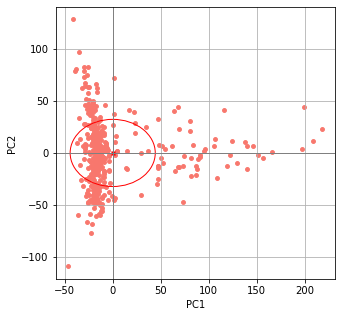

In [24]:
fig, ax = plt.subplots(figsize=(5,5))

pca = sklearnPCA(n_components=2)

Y = pca.fit_transform(tcga_norm.to_numpy()/1000)

x1 = Y[:,0]
y1 = Y[:,1]

mu_x1 = np.mean(x1)
mu_y1 = np.mean(y1)
    
ax.scatter(x1, y1, s=15,color = "#F8776D")
confidence_ellipse(x1, y1, ax,n_std=1, edgecolor='red')
ax.scatter(mu_x1, mu_y1, c='red', s=15,marker="x")

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

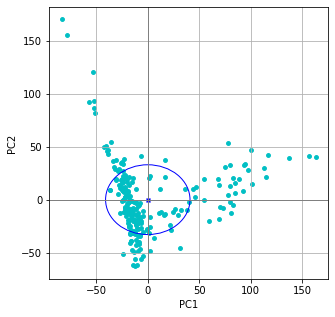

In [28]:
fig, ax = plt.subplots(figsize=(5,5))

pca = sklearnPCA(n_components=2)

Y = pca.fit_transform(icgc_norm.to_numpy()/1000)

x1 = Y[:,0]
y1 = Y[:,1]

mu_x1 = np.mean(x1)
mu_y1 = np.mean(y1)
    
ax.scatter(x1, y1, s=15,color = "#01BFC4")
confidence_ellipse(x1, y1, ax,n_std=1, edgecolor='blue')
ax.scatter(mu_x1, mu_y1, c='blue', s=15,marker="x")

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

In [182]:

#X1 = pd.DataFrame(StandardScaler().fit_transform(tcga_norm)).set_axis(tcga_norm.columns, axis=1, inplace=False)
#X2 = pd.DataFrame(StandardScaler().fit_transform(icgc_norm)).set_axis(icgc_norm.columns, axis=1, inplace=False)
#dataset1 = pd.concat([X1,X2], axis=0).fillna(0)

dataset1 = pd.concat([tcga_norm,icgc_norm], axis=0).fillna(0)

dataset1

gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AANAT,...,VKORC1,VKORC1L1,WBSCR17,WWOX,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
0,284.551280,5.269568,2.035236,13.094908,1784.107901,0.000000,0.000000,0.000000,14.093056,0.451001,...,367.429106,67.498655,0.000000,0.599981,75.024809,81.033772,0.999657,24.113762,5.383372,252.403501
1,243.018423,5.274831,3.111411,39.221187,624.948765,0.000000,0.125485,0.000000,7.208089,0.378537,...,993.732202,74.591917,0.008187,0.634225,65.877956,21.335823,3.851182,52.400159,1.219968,426.297122
2,118.638287,15.059457,0.000000,5.697572,1418.300952,0.000000,0.000000,0.000000,20.611051,0.283832,...,1408.108569,30.844054,0.016369,0.645467,20.204425,14.631527,0.905937,13.950709,3.930038,92.902250
3,153.723473,6.845525,0.000000,4.636319,2514.727731,0.000000,0.107460,0.000000,28.446059,0.405201,...,1137.908333,33.788513,0.014021,0.795762,144.231139,30.967774,1.357987,33.478846,1.973366,74.710528
4,188.898001,24.316815,0.000000,8.996801,1666.342222,0.000000,0.000000,0.000000,14.767589,0.389125,...,2241.455776,35.797061,0.145869,0.665150,71.088365,61.555590,2.794518,20.049642,3.622930,134.008990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,0.295213,37.019155,4.941815,11.691130,12.599843,0.000000,0.499212,0.280049,4.801763,5.376930,...,908.919953,12.584751,0.086848,0.458195,0.078514,1.923341,18.365718,17.821109,220.445090,292.227403
228,204.862033,17.400947,3.592561,21.453247,1660.785219,0.000000,0.000000,0.000000,42.734778,0.223000,...,2047.056628,12.448244,0.000000,1.921935,13.884228,104.782311,1.367284,36.562330,218.937718,388.917242
229,405.504087,4.481528,0.269894,14.820911,4855.800656,0.110662,0.000000,0.000000,17.874738,0.211399,...,1057.385950,6.422544,0.010060,0.558373,7.621406,34.114946,1.020385,16.838723,111.749930,126.863122
230,146.223049,3.652725,0.731584,11.753061,1051.115971,0.000000,0.000000,0.000000,47.198044,0.085205,...,459.084249,15.099597,0.005454,0.489722,28.986753,36.997261,0.991695,18.279252,130.380800,104.948002


In [183]:
df = dataset1

s = pd.Series(patient_id+icgc_donor_list)


df = df.set_index([s])
df  = df.rename_axis('gene_id', axis=1)
df  = df.rename_axis('donor_id', axis=0)

dataset1 = df
dataset1.T

donor_id,d1cbb686-93d8-4349-8bf5-756887c60ebc,0b530162-4c93-42cb-a2b0-4948d19963bd,20fc6696-a863-47ea-90d2-802507928248,69445314-a0b0-4b88-8aab-6f4659249288,933f420d-7898-45c3-8b0f-bef9840aea7d,571f8fb1-0668-4443-a193-f4bdea78caef,104c7c7e-583a-4496-a685-5d277e28c11b,75adfb0c-a04e-46c6-b5d3-ccc41122f798,09f395dd-d007-41e0-8a51-a6533ae51087,8040a1f5-5f45-4e92-9f77-78e123afa270,...,DO23528,DO23527,DO23526,DO23525,DO23524,DO23523,DO23521,DO23529,DO23509,DO23508
gene_id,,,,,,,,,,,,,,,,,,,,,
A1CF,284.551280,243.018423,118.638287,153.723473,188.898001,384.840396,274.928282,214.249854,101.467544,409.151596,...,316.641552,306.219539,231.188674,181.651015,120.329499,0.295213,204.862033,405.504087,146.223049,106.863570
A4GALT,5.269568,5.274831,15.059457,6.845525,24.316815,20.110140,9.077620,24.789981,19.355058,14.001338,...,6.824529,7.335714,20.124339,7.776483,16.877361,37.019155,17.400947,4.481528,3.652725,8.196839
A4GNT,2.035236,3.111411,0.000000,0.000000,0.000000,2.352656,0.000000,0.206012,0.215704,2.243995,...,1.826339,0.530767,20.672819,0.000000,4.379342,4.941815,3.592561,0.269894,0.731584,0.000000
AACS,13.094908,39.221187,5.697572,4.636319,8.996801,25.458701,22.911552,9.415973,21.493036,24.156156,...,6.690886,5.217829,50.348873,15.469748,19.981986,11.691130,21.453247,14.820911,11.753061,22.718691
AADAC,1784.107901,624.948765,1418.300952,2514.727731,1666.342222,2614.874849,630.627395,3499.912254,991.453651,317.960276,...,973.292133,2441.228965,750.045148,1096.221561,2031.014415,12.599843,1660.785219,4855.800656,1051.115971,985.994433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYLB,81.033772,21.335823,14.631527,30.967774,61.555590,30.414694,65.996140,56.124237,46.104247,202.387475,...,109.948836,35.780824,27.626109,31.877947,33.429310,1.923341,104.782311,34.114946,36.997261,12.953450
XYLT1,0.999657,3.851182,0.905937,1.357987,2.794518,5.898718,0.691089,6.374842,1.601943,4.999551,...,1.376923,4.914607,5.004022,0.544402,4.418321,18.365718,1.367284,1.020385,0.991695,0.402343
XYLT2,24.113762,52.400159,13.950709,33.478846,20.049642,55.276775,16.512169,24.582452,18.790315,40.120607,...,26.252725,15.241920,40.844723,26.105606,25.195574,17.821109,36.562330,16.838723,18.279252,19.500970


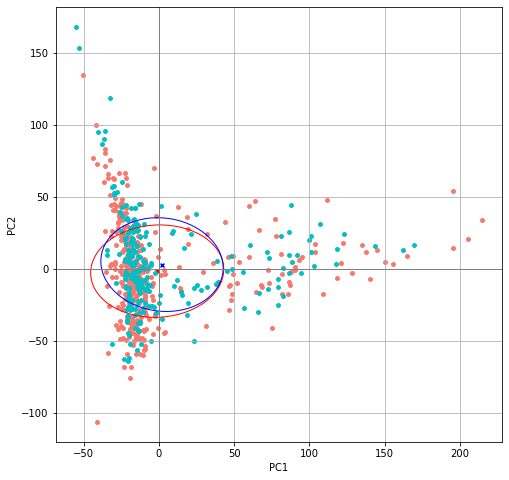

In [184]:
fig, ax = plt.subplots(figsize=(8,8))

pca = sklearnPCA(n_components=2)

Y = pca.fit_transform(dataset1.to_numpy()/1000)

#####################################################################

x1 = Y[:371,0]
y1 = Y[:371,1]

mu_x1 = np.mean(x1)
mu_y1 = np.mean(y1)
    
ax.scatter(x1, y1, s=15,color = "#F8776D")
confidence_ellipse(x1, y1, ax,n_std=1, edgecolor='red')
ax.scatter(mu_x1, mu_y1, c='red', s=15,marker="x")

#####################################################################

x2 = Y[371:,0]
y2 = Y[371:,1]

mu_x2 = np.mean(x2)
mu_y2 = np.mean(y2)

ax.scatter(x2, y2, s=15,color = "#01BFC4")
confidence_ellipse(x2, y2, ax,n_std=1, edgecolor='blue')
ax.scatter(mu_x2, mu_y2, c='blue', s=15,marker="x")

#####################################################################

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

In [185]:
from combat.pycombat import pycombat

print(np.shape(complete),np.shape(tcga.astype(float)),np.shape(icgc.astype(float)))

df = dataset1.T

dataset1 = tcga.astype(float).T
dataset2 = icgc.astype(float).T

print(np.shape(dataset1),np.shape(dataset2))

df_expression = pd.concat([dataset1,dataset2],join="inner",axis=1)

batch = []
datasets = [dataset1,dataset2]

for j in range(len(datasets)):
    batch.extend([j for _ in range(len(datasets[j].columns))])
    
print(np.shape(batch))

df_corrected = pycombat(df_expression,batch)

print("end")

(603, 19856) (371, 2673) (232, 2673)
(2673, 371) (2673, 232)
(603,)
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
end


/home/sven/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


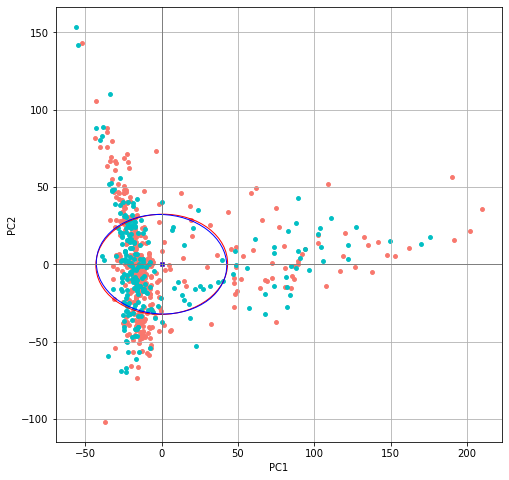

In [186]:
fig, ax = plt.subplots(figsize=(8,8))

pca = sklearnPCA(n_components=2)

Y = pca.fit_transform(df_corrected.T.to_numpy()/1000)

x1 = Y[:371,0]
y1 = Y[:371,1]

mu_x1 = np.mean(x1)
mu_y1 = np.mean(y1)
    
ax.scatter(x1, y1, s=15,color = "#F8776D")
confidence_ellipse(x1, y1, ax,n_std=1, edgecolor='red')
ax.scatter(mu_x1, mu_y1, c='red', s=15,marker="x")

x2 = Y[371:,0]
y2 = Y[371:,1]

mu_x2 = np.mean(x2)
mu_y2 = np.mean(y2)

ax.scatter(x2, y2, s=15,color = "#01BFC4")
confidence_ellipse(x2, y2, ax,n_std=1, edgecolor='blue')
ax.scatter(mu_x2, mu_y2, c='blue', s=15,marker="x")

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
import matplotlib.ticker as mticker
ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mticker.MultipleLocator(50))
plt.grid()
plt.show()

In [187]:
from scipy import stats

df = df_corrected
MAD = []
indexs=[]
for num,(index, row) in enumerate(df.iterrows()):
    mad = stats.median_abs_deviation(row)
    MAD.append(mad)
    if mad < 0.5:
        #print(num,mad) 
        indexs.append(num)
        
print(len(indexs))

newdf  = df.T.drop(df.T.columns[indexs], axis = 1)
DF = newdf.reindex(sorted(newdf.columns), axis=1)
DF

492


gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADAT,AASDH,AASDHPPT,AASS,ABAT,...,VDAC2,VDAC3,VKORC1,VKORC1L1,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
donor_id,,,,,,,,,,,,,,,,,,,,,
d1cbb686-93d8-4349-8bf5-756887c60ebc,327.580024,4.565263,1.503392,12.572493,1805.123528,17.002015,11.552261,217.597635,87.000796,193.012594,...,273.725532,746.794559,392.847768,50.542797,82.711193,81.331374,1.308525,23.424147,90.170078,280.955929
0b530162-4c93-42cb-a2b0-4948d19963bd,277.993195,4.569869,2.895887,40.028381,715.065094,10.587053,30.182355,87.893141,15.342392,71.398113,...,554.191792,544.752134,1076.825827,56.229376,71.201324,21.310214,5.135460,50.208414,66.353808,474.279722
20fc6696-a863-47ea-90d2-802507928248,129.493501,13.134280,-1.130063,4.798694,1461.123349,23.075056,9.003491,105.145072,79.464835,173.672689,...,145.023418,343.932747,1529.361260,21.157264,13.728403,14.569620,1.182746,13.800796,81.856447,103.632650
69445314-a0b0-4b88-8aab-6f4659249288,171.382339,5.944686,-1.130063,3.683432,2492.189076,30.375204,3.575955,83.402545,136.891997,186.029184,...,128.765207,368.237877,1234.278841,23.517800,169.796421,30.994313,1.789428,32.291904,70.663530,83.408259
933f420d-7898-45c3-8b0f-bef9840aea7d,213.377844,21.237178,-1.130063,8.265827,1694.378189,17.630500,16.007001,88.856381,14.632866,253.035994,...,312.346044,219.786439,2439.449698,25.128027,77.757799,61.747736,3.717348,19.575849,80.099674,149.332493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO23523,5.975748,50.825808,4.285170,12.523481,-240.990008,-2.483306,16.094313,147.720103,-2.620187,2.035854,...,398.263015,590.929698,807.526151,37.964067,7.916621,2.194635,13.764792,18.536899,97.960197,252.651616
DO23521,174.365200,23.501875,3.232084,21.621618,1610.067465,41.050697,18.785534,171.686330,6.968554,135.138792,...,215.510492,769.587983,1822.297763,37.575333,18.875453,104.139793,0.760138,39.263981,97.017666,337.301206
DO23529,339.523976,5.507910,0.638759,15.440387,5198.351456,12.519955,18.856227,139.207263,81.918175,168.744628,...,150.630730,111.869856,939.899602,20.415830,13.904091,34.100246,0.494743,17.450417,29.995134,107.879231


In [188]:
final_genes=pd.read_excel("mol212639-sup-0006-tables1-s11.xlsx",
                  sheet_name="Table S1")

df = final_genes

new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

df

final_set = set(df["Gene Symbol"].tolist())

In [189]:
len(set.intersection(set(DF.columns),final_set))

815

# SURVIVAL

In [190]:
TCGA_clinical = pd.read_csv("clinical.tsv", sep='\t')

df = pd.read_json('metadata.cart.2021-12-03.json')
metadata = df[df['data_category'].str.contains('Transcriptome Profiling')].reset_index().drop(columns=["index"])

files=[]

d = dict()
for i in range(len(metadata["associated_entities"].values)):
    temp = []
    for key,item in metadata.iloc[i,[2]]["associated_entities"][0].items():
        
        if key == "entity_submitter_id":
            temp.append(str(item)[:-16])
            
    file = metadata.iloc[i,[3]]["file_name"]
    
    if str(file)[-16:]==".htseq.counts.gz":
        temp.append(metadata.iloc[i,[3]]["file_name"])
        files.append(file)
    else:
        temp.append("9700948e-21f5-42ae-9cb5-f18c745887ce.htseq.counts.gz")
    
    d[temp[0]]=temp[1]
    

files = pd.DataFrame(d.items(), columns=['case_submitter_id', 'file_name'])

TCGA_CL = TCGA_clinical.drop_duplicates(subset=['case_id'], keep='first')[["case_submitter_id","days_to_last_follow_up","days_to_death","vital_status"]].reset_index().drop(columns=["index"])

CL = pd.merge(files,TCGA_CL,on="case_submitter_id")

df = CL

df.loc[(df.vital_status == 'Dead'),'days_to_last_follow_up']=""

df = df.replace("'--", "")
#df = df.replace("0", "")

df['donor_survival_time']=df['days_to_last_follow_up']+df['days_to_death']

d = {'Alive': 1, 'Dead': 0}
data2 =  df['vital_status'].map(d)

df["status"] = data2
A = df[["donor_survival_time","status"]]

ICGC_clinical = pd.read_csv('donor.tsv', sep='\t')#,header=0)
ICGC_clinical[["donor_vital_status","donor_survival_time"]]

data = ICGC_clinical[["donor_vital_status","donor_survival_time"]]

d = {'alive': 1, 'deceased': 0}
data2 =  data['donor_vital_status'].map(d)

data["status"] = data2
data[["donor_survival_time","status"]]

B = data[["donor_survival_time","status"]]

clinical_data = pd.concat([A,B])
clinical_data = clinical_data.reset_index().drop(columns=["index"])

clinical_data = clinical_data.drop(316) #missing time
clinical_data = clinical_data.drop(43) #missing status

clinical_data

<ipython-input-190-852bc54aab3c>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["status"] = data2


,donor_survival_time,status
0,1219,1.0
1,538,1.0
2,211,1.0
3,9,1.0
4,601,0.0
...,...,...
598,1080,1.0
599,1110,1.0
600,930,1.0
601,780,0.0


In [191]:
DF

gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADAT,AASDH,AASDHPPT,AASS,ABAT,...,VDAC2,VDAC3,VKORC1,VKORC1L1,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
donor_id,,,,,,,,,,,,,,,,,,,,,
d1cbb686-93d8-4349-8bf5-756887c60ebc,327.580024,4.565263,1.503392,12.572493,1805.123528,17.002015,11.552261,217.597635,87.000796,193.012594,...,273.725532,746.794559,392.847768,50.542797,82.711193,81.331374,1.308525,23.424147,90.170078,280.955929
0b530162-4c93-42cb-a2b0-4948d19963bd,277.993195,4.569869,2.895887,40.028381,715.065094,10.587053,30.182355,87.893141,15.342392,71.398113,...,554.191792,544.752134,1076.825827,56.229376,71.201324,21.310214,5.135460,50.208414,66.353808,474.279722
20fc6696-a863-47ea-90d2-802507928248,129.493501,13.134280,-1.130063,4.798694,1461.123349,23.075056,9.003491,105.145072,79.464835,173.672689,...,145.023418,343.932747,1529.361260,21.157264,13.728403,14.569620,1.182746,13.800796,81.856447,103.632650
69445314-a0b0-4b88-8aab-6f4659249288,171.382339,5.944686,-1.130063,3.683432,2492.189076,30.375204,3.575955,83.402545,136.891997,186.029184,...,128.765207,368.237877,1234.278841,23.517800,169.796421,30.994313,1.789428,32.291904,70.663530,83.408259
933f420d-7898-45c3-8b0f-bef9840aea7d,213.377844,21.237178,-1.130063,8.265827,1694.378189,17.630500,16.007001,88.856381,14.632866,253.035994,...,312.346044,219.786439,2439.449698,25.128027,77.757799,61.747736,3.717348,19.575849,80.099674,149.332493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DO23523,5.975748,50.825808,4.285170,12.523481,-240.990008,-2.483306,16.094313,147.720103,-2.620187,2.035854,...,398.263015,590.929698,807.526151,37.964067,7.916621,2.194635,13.764792,18.536899,97.960197,252.651616
DO23521,174.365200,23.501875,3.232084,21.621618,1610.067465,41.050697,18.785534,171.686330,6.968554,135.138792,...,215.510492,769.587983,1822.297763,37.575333,18.875453,104.139793,0.760138,39.263981,97.017666,337.301206
DO23529,339.523976,5.507910,0.638759,15.440387,5198.351456,12.519955,18.856227,139.207263,81.918175,168.744628,...,150.630730,111.869856,939.899602,20.415830,13.904091,34.100246,0.494743,17.450417,29.995134,107.879231


In [192]:
df = DF.reset_index().drop(columns=["donor_id"])
df

gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADAT,AASDH,AASDHPPT,AASS,ABAT,...,VDAC2,VDAC3,VKORC1,VKORC1L1,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2
0,327.580024,4.565263,1.503392,12.572493,1805.123528,17.002015,11.552261,217.597635,87.000796,193.012594,...,273.725532,746.794559,392.847768,50.542797,82.711193,81.331374,1.308525,23.424147,90.170078,280.955929
1,277.993195,4.569869,2.895887,40.028381,715.065094,10.587053,30.182355,87.893141,15.342392,71.398113,...,554.191792,544.752134,1076.825827,56.229376,71.201324,21.310214,5.135460,50.208414,66.353808,474.279722
2,129.493501,13.134280,-1.130063,4.798694,1461.123349,23.075056,9.003491,105.145072,79.464835,173.672689,...,145.023418,343.932747,1529.361260,21.157264,13.728403,14.569620,1.182746,13.800796,81.856447,103.632650
3,171.382339,5.944686,-1.130063,3.683432,2492.189076,30.375204,3.575955,83.402545,136.891997,186.029184,...,128.765207,368.237877,1234.278841,23.517800,169.796421,30.994313,1.789428,32.291904,70.663530,83.408259
4,213.377844,21.237178,-1.130063,8.265827,1694.378189,17.630500,16.007001,88.856381,14.632866,253.035994,...,312.346044,219.786439,2439.449698,25.128027,77.757799,61.747736,3.717348,19.575849,80.099674,149.332493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,5.975748,50.825808,4.285170,12.523481,-240.990008,-2.483306,16.094313,147.720103,-2.620187,2.035854,...,398.263015,590.929698,807.526151,37.964067,7.916621,2.194635,13.764792,18.536899,97.960197,252.651616
599,174.365200,23.501875,3.232084,21.621618,1610.067465,41.050697,18.785534,171.686330,6.968554,135.138792,...,215.510492,769.587983,1822.297763,37.575333,18.875453,104.139793,0.760138,39.263981,97.017666,337.301206
600,339.523976,5.507910,0.638759,15.440387,5198.351456,12.519955,18.856227,139.207263,81.918175,168.744628,...,150.630730,111.869856,939.899602,20.415830,13.904091,34.100246,0.494743,17.450417,29.995134,107.879231
601,126.096442,4.353566,0.999106,12.581200,925.355154,46.172985,8.217365,57.830954,697.850186,164.114659,...,118.440826,584.448311,406.449099,45.125643,30.863681,36.956954,0.472793,19.043588,41.644671,88.693079


In [193]:
COMP = df

COMP["time"] = clinical_data[["donor_survival_time"]]
COMP["status"] = clinical_data[["status"]]

comp = COMP.drop(316) #missing time
comp = comp.drop(43) #missing status

comp

gene_id,A1CF,A4GALT,A4GNT,AACS,AADAC,AADAT,AASDH,AASDHPPT,AASS,ABAT,...,VKORC1,VKORC1L1,XDH,XYLB,XYLT1,XYLT2,ZACN,ZADH2,time,status
0,327.580024,4.565263,1.503392,12.572493,1805.123528,17.002015,11.552261,217.597635,87.000796,193.012594,...,392.847768,50.542797,82.711193,81.331374,1.308525,23.424147,90.170078,280.955929,1219,1.0
1,277.993195,4.569869,2.895887,40.028381,715.065094,10.587053,30.182355,87.893141,15.342392,71.398113,...,1076.825827,56.229376,71.201324,21.310214,5.135460,50.208414,66.353808,474.279722,538,1.0
2,129.493501,13.134280,-1.130063,4.798694,1461.123349,23.075056,9.003491,105.145072,79.464835,173.672689,...,1529.361260,21.157264,13.728403,14.569620,1.182746,13.800796,81.856447,103.632650,211,1.0
3,171.382339,5.944686,-1.130063,3.683432,2492.189076,30.375204,3.575955,83.402545,136.891997,186.029184,...,1234.278841,23.517800,169.796421,30.994313,1.789428,32.291904,70.663530,83.408259,9,1.0
4,213.377844,21.237178,-1.130063,8.265827,1694.378189,17.630500,16.007001,88.856381,14.632866,253.035994,...,2439.449698,25.128027,77.757799,61.747736,3.717348,19.575849,80.099674,149.332493,601,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,5.975748,50.825808,4.285170,12.523481,-240.990008,-2.483306,16.094313,147.720103,-2.620187,2.035854,...,807.526151,37.964067,7.916621,2.194635,13.764792,18.536899,97.960197,252.651616,1080,1.0
599,174.365200,23.501875,3.232084,21.621618,1610.067465,41.050697,18.785534,171.686330,6.968554,135.138792,...,1822.297763,37.575333,18.875453,104.139793,0.760138,39.263981,97.017666,337.301206,1110,1.0
600,339.523976,5.507910,0.638759,15.440387,5198.351456,12.519955,18.856227,139.207263,81.918175,168.744628,...,939.899602,20.415830,13.904091,34.100246,0.494743,17.450417,29.995134,107.879231,930,1.0
601,126.096442,4.353566,0.999106,12.581200,925.355154,46.172985,8.217365,57.830954,697.850186,164.114659,...,406.449099,45.125643,30.863681,36.956954,0.472793,19.043588,41.644671,88.693079,780,0.0


In [194]:
comp.to_pickle("genes_2183.pkl")

# COX

In [195]:
def cox_proportional_hazard_model(data, survival_duration, survival_status, strata=None):

    cph = CoxPHFitter(alpha=0.05, penalizer=0.1, strata=None)

    cph.fit(df=data, 
            duration_col=survival_duration, event_col=survival_status, 
            strata=strata, show_progress=True, step_size=0.1)

    cph.print_summary()

    return cph

In [196]:
df = comp

cph0 = CoxPHFitter()
#cph.fit(rossi, 'week', 'arrest')
cph0.fit(df.iloc[:,[0,len(df.columns)-2,len(df.columns)-1]], "time", "status")
cph0.print_summary()

<lifelines.CoxPHFitter: fitted with 601 total observations, 173 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 601
number of events observed = 428
   partial log-likelihood = -2332.32
         time fit was run = 2022-01-15 11:56:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
A1CF        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

             z    p   -log2(p)
covariate                     
A1CF      1.39 0.16       2.60
---
Concordance = 0.48
Partial AIC = 4666.63
log-likelihood ratio test = 1.90 on 1 df
-log2(p) of ll-ratio test = 2.57

In [197]:
cph = cox_proportional_hazard_model(df,"time","status",strata=None)

Iteration 1: norm_delta = 2.27313, step_size = 0.1000, log_lik = -2333.26561, newton_decrement = 341.96752, seconds_since_start = 31.0
Iteration 2: norm_delta = 1.91757, step_size = 0.1000, log_lik = -2268.36653, newton_decrement = 264.41641, seconds_since_start = 62.3
Iteration 3: norm_delta = 1.70078, step_size = 0.1000, log_lik = -2218.13683, newton_decrement = 213.42966, seconds_since_start = 93.6
Iteration 4: norm_delta = 1.47292, step_size = 0.1300, log_lik = -2166.24224, newton_decrement = 164.26282, seconds_since_start = 124.9
Iteration 5: norm_delta = 1.23779, step_size = 0.1690, log_lik = -2115.36506, newton_decrement = 118.82372, seconds_since_start = 155.8
Iteration 6: norm_delta = 1.00755, step_size = 0.2197, log_lik = -2068.77134, newton_decrement = 79.39980, seconds_since_start = 187.1
Iteration 7: norm_delta = 0.79186, step_size = 0.2856, log_lik = -2029.68052, newton_decrement = 47.29869, seconds_since_start = 218.2
Iteration 8: norm_delta = 0.56407, step_size = 0.3713

<lifelines.CoxPHFitter: fitted with 601 total observations, 173 right-censored observations>
             duration col = 'time'
                event col = 'status'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 601
number of events observed = 428
   partial log-likelihood = -1975.81
         time fit was run = 2022-01-15 11:56:06 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
A1CF         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
A4GALT      -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
A4GNT        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
AACS        -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
AADAC       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
AADAT       -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
AASDH        0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
AASDHPPT    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
AASS        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ABAT         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ABCA1        0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
ABCA10       0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
ABCA2       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ABCA3        0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
ABCA4       -0.01       0.99       0.03            -0.07             0.05                 0.93                 1.05
ABCA5       -0.00       1.00       0.00            -0.01             0.00                 1.00                 1.00
ABCA6       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ABCA7        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ABCA8       -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
ABCA9       -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
ABCB1        0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
ABCB10       0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
ABCB11      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ABCB4        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ABCB6        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ABCB7        0.01       1.01       0.02            -0.03             0.04                 0.97                 1.04
ABCB8       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ABCB9        0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
ABCC1       -0.00       1.00       0.01            -0.01             0.01                 0.99   

In [198]:
def print_summary(cph, decimals=2, style=None, columns=None, **kwargs):

        self = cph
        headers = []

        footers = []
        sr = self.log_likelihood_ratio_test()
        
        p = Printer(cph, headers, footers, 0, kwargs, decimals, columns)
        
        return (p.model.summary["p"])

In [199]:
data = print_summary(cph)

In [205]:
suma = 0
for index,(i,j) in enumerate(data.items()):
    
    if j>=0.95:
        suma+=1
        print(i,j)

A4GALT 0.9723039459210826
A4GNT 0.9921271625553051
AACS 0.9534220871726014
ABCA5 0.9578683215962837
ABCB10 0.9658453853611878
ABCB9 0.9809167391334956
ABCF3 0.9835809271590007
ABHD10 0.9973865949746403
ABHD14B 0.9900702986700569
ACACA 0.9514985557329042
ACO2 0.959208289134089
ACSF3 0.9627854391005316
ACSL1 0.9815451898780894
ACSM2B 0.9940891478356003
ACSM5 0.9855032996814773
ACY3 0.9936535100733651
ACYP1 0.9861812312066001
ADCY3 0.9568561530817071
ADCY6 0.9766679565642793
ADH5 0.9567442556054933
ADH7 0.9717111033870433
ADI1 0.9827618738990075
ADO 0.9841978856600696
ADPGK 0.9646224701148268
ADSL 0.9822040863992721
AFMID 0.9551234932450325
AGK 0.9878851308499569
AHCYL1 0.9753350226756441
AKR1C3 0.9855138312230665
AKR7L 0.9711582896383779
ALAS1 0.956871200453688
ALDH1A3 0.9655362200932217
ALDH3A2 0.9999940090668783
ALDH5A1 0.9978024295126126
ALDH7A1 0.9728205834957276
ALDOA 0.9728711094465198
APRT 0.9538636041734492
ASPG 0.9587062176100476
ATP11B 0.9547185947111658
ATP11C 0.95745735685452